<a href="https://colab.research.google.com/github/OziomaEunice/Sentiment_GPT/blob/develop/SVM_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SVM for Sentiment Analysis**

### **Install and import libraries**

In [1]:
# install the necessary libraries
! pip install numpy
! pip install pandas
! pip install scikit-learn
! pip install nltk
! pip install openpyxl # for reading excel files

In [2]:
# import the necessary libraries
import numpy as np
import pandas as pd
import nltk
import re
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [3]:
# Download the stopwords dataset
nltk.download('stopwords')

# Download wordnet dataset
nltk.download('wordnet')

# Download punkt dataset
nltk.download('punkt')

# Get the set of English stop words
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### **Get Datasets**

In [4]:
# since dataset is imported to my Google Colab (which will remain in here temporary)
# read excel file
df = pd.read_excel('/content/Tweets.xlsx') # for Twitter dataset
df2 = pd.read_excel('/content/IMDB_Dataset.xlsx') # for IMDb Movie Review dataset

In [5]:
# check the number of rows and columns
df.shape

(14640, 15)

In [6]:
df2.shape

(50000, 2)

In [7]:
# show Twitter dataframe
df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760512,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:00,NaN,Pacific Time (US & Canada)
2,570301083672813568,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:00,Lets Play,Central Time (US & Canada)
3,570301031407624192,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:00,NaN,Pacific Time (US & Canada)
4,570300817074462720,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:00,NaN,Pacific Time (US & Canada)
5,570300767074181120,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:00,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:00,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:00,Los Angeles,Pacific Time (US & Canada)
8,570299953286942720,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:00,San Diego,Pacific Time (US & Canada)
9,570295459631263744,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:00,Los Angeles,Eastern Time (US & Canada)


In [8]:
# show IMDb dataset
df2.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [9]:
# datatype info
df.info()

print('\n***========================***\n')

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   tweet_id                      14640 non-null  int64         
 1   airline_sentiment             14640 non-null  object        
 2   airline_sentiment_confidence  14640 non-null  float64       
 3   negativereason                9178 non-null   object        
 4   negativereason_confidence     10522 non-null  float64       
 5   airline                       14640 non-null  object        
 6   airline_sentiment_gold        40 non-null     object        
 7   name                          14640 non-null  object        
 8   negativereason_gold           32 non-null     object        
 9   retweet_count                 14640 non-null  int64         
 10  text                          14640 non-null  object        
 11  tweet_coord                 

In [10]:
# counting the number of missing values in the dataset
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [11]:
df2.isnull().sum()

review       0
sentiment    0
dtype: int64

### **Visualisation (before preprocessing)**

#### **Twitter**

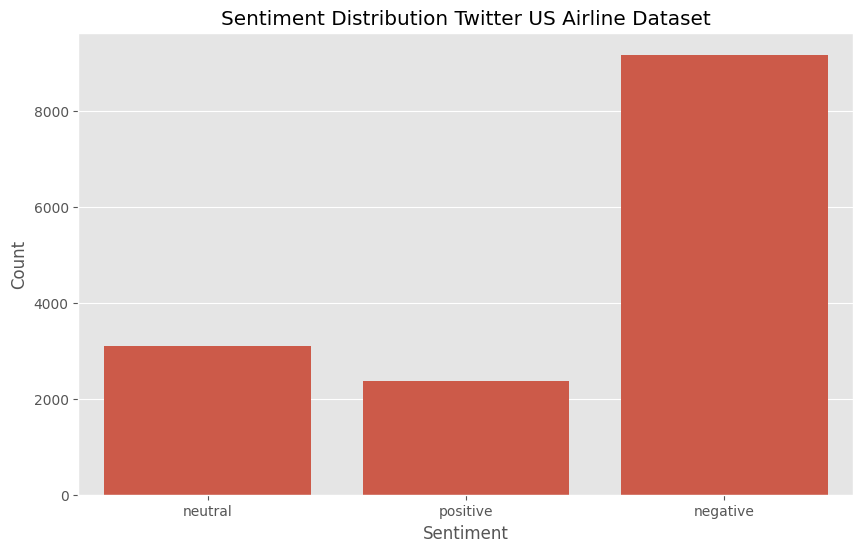

In [12]:
# Visualize sentiment distribution before preprocessing
plt.figure(figsize=(10, 6))
sns.countplot(x='airline_sentiment', data=df)
plt.title('Sentiment Distribution Twitter US Airline Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

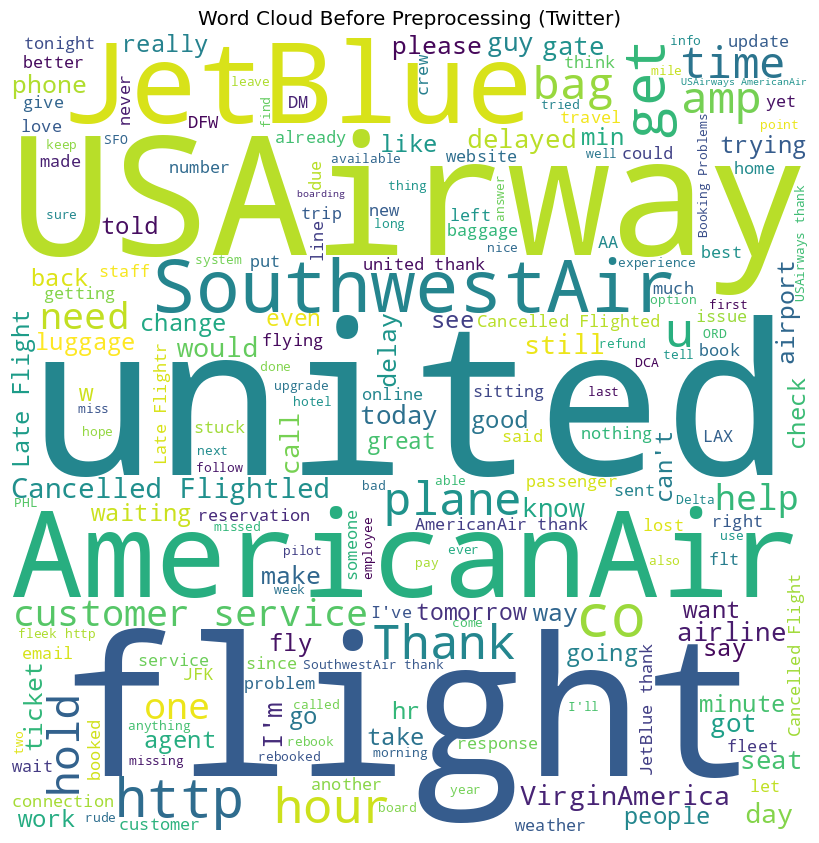

In [13]:
# Visualise sentiment in wordcloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stop_words,
                min_font_size = 10).generate(text)

    # Plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title)
    plt.show()

# Visualize word cloud before preprocessing for Twitter dataset
generate_wordcloud(' '.join(df['text'].values), 'Word Cloud Before Preprocessing (Twitter)')

#### **IMDb**

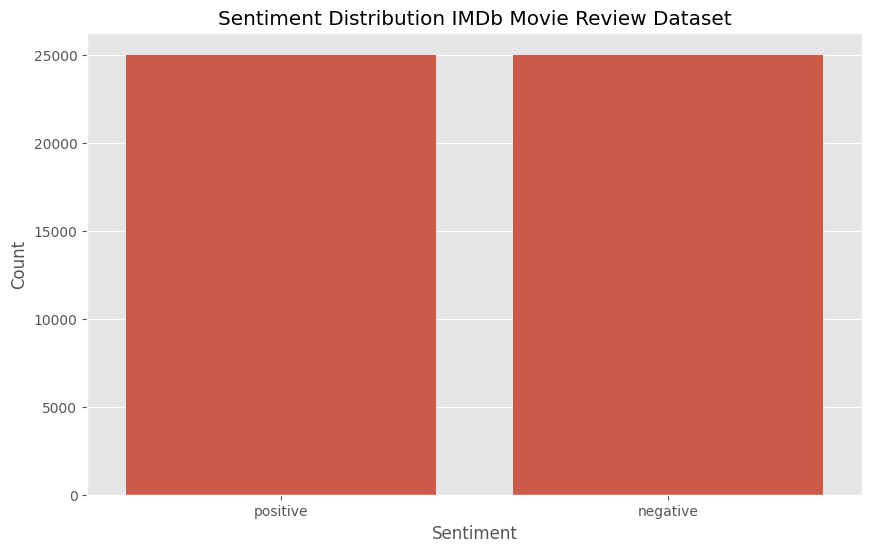

In [14]:
# Visualize sentiment distribution before preprocessing
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df2)
plt.title('Sentiment Distribution IMDb Movie Review Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

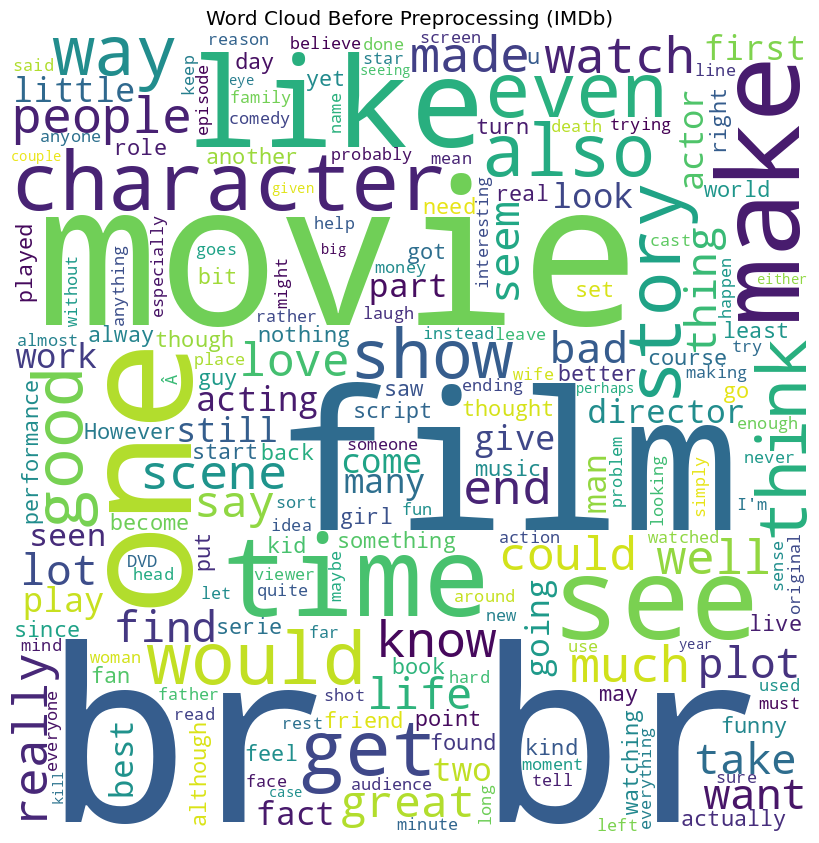

In [15]:
# Visualize word cloud before preprocessing for IMDb dataset
generate_wordcloud(' '.join(df2['review'].values), 'Word Cloud Before Preprocessing (IMDb)')

## **Preprocessing Dataset**

### **Handling Missing Values**

In [16]:
# drop columns that are not needed for processing data
# In this case, for the Twitter dataset
df = df.drop(columns=['tweet_id', 'airline_sentiment_gold', 'negativereason', 'negativereason_confidence', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location', 'user_timezone'])

In [17]:
df.isnull().sum()

airline_sentiment               0
airline_sentiment_confidence    0
airline                         0
name                            0
text                            0
dtype: int64

In [18]:
df.head(10)

,airline_sentiment,airline_sentiment_confidence,airline,name,text
0,neutral,1.0000,Virgin America,cairdin,@VirginAmerica What @dhepburn said.
1,positive,0.3486,Virgin America,jnardino,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,Virgin America,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,Virgin America,jnardino,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,Virgin America,jnardino,@VirginAmerica and it's a really big bad thing...
5,negative,1.0000,Virgin America,jnardino,@VirginAmerica seriously would pay $30 a fligh...
6,positive,0.6745,Virgin America,cjmcginnis,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,0.6340,Virgin America,pilot,@VirginAmerica Really missed a prime opportuni...
8,positive,0.6559,Virgin America,dhepburn,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,1.0000,Virgin America,YupitsTate,"@VirginAmerica it was amazing, and arrived an ..."


### **Cleaning Dataset**

In [19]:
# clean (preprocess) the Twitter dataset
def cleanData1(text, min_word_length = 3):
  text = text.lower()
  text = re.sub(r'@[A-Za-z0-9]+', "", text) # this informs Python the the mentions in text must be substituted with an empty string
  text = re.sub(r'#', "", text) # removing #
  text = re.sub(r'RT[\s]+', "", text) # removing retweets
  text = re.sub(r'https?:\/\/\S+', "", text) # removing links
  text = ' '.join(word for word in text.split() if len(word) >= min_word_length and word not in stop_words) # Remove short words

  punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
  for p in punctuations:
      text = text.replace(p,'') #Removing punctuations

  # Lemmatize the words
  words = nltk.word_tokenize(text)
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  text = ' '.join(lemmatized_words)

  return text

In [20]:
# clean (preprocess) the IMDb Movie Review dataset
def cleanData2(review, min_word_length = 3):
  review = review.lower()
  review = re.sub(r'@[A-Za-z0-9]+', "", review) # this informs Python the the mentions in text must be substituted with an empty string
  review = re.sub(r'#', "", review) # removing #
  review = re.sub(r'RT[\s]+', "", review) # removing retweets
  review = re.sub(r'https?:\/\/\S+', "", review) # removing links
  review = ' '.join(word for word in review.split() if len(word) >= min_word_length and word not in stop_words) # Remove short words

  punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
  for p in punctuations:
      review = review.replace(p,'') #Removing punctuations

  # Lemmatize the words
  words = nltk.word_tokenize(review)
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  review= ' '.join(lemmatized_words)

  return review

In [21]:
# df['text'] = df['text'].apply(cleanData)

# Apply the cleanData function to all text columns in the dataframe
df = df.applymap(lambda x: cleanData1(x) if isinstance(x, str) else x)

In [22]:
df2 = df2.applymap(lambda x: cleanData2(x) if isinstance(x, str) else x)

### **Visualisation (after preprocessing)**

#### **Twitter**

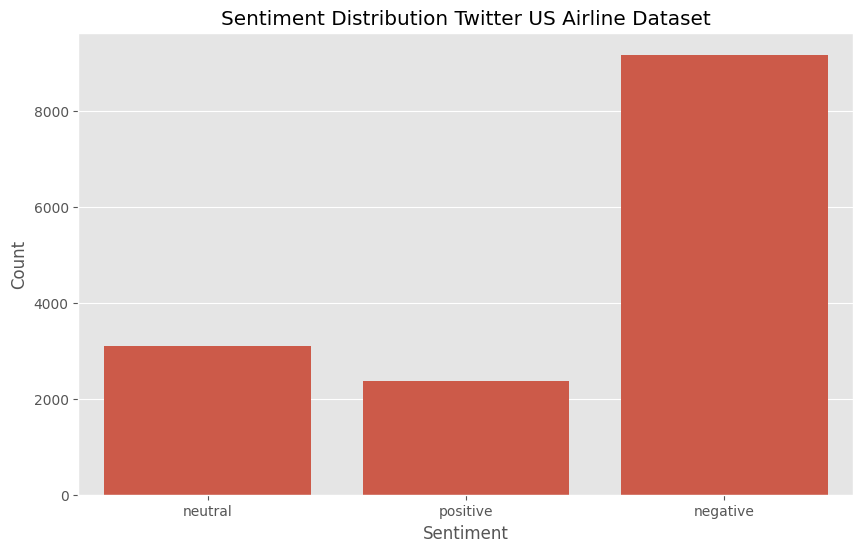

In [23]:
# Visualize sentiment distribution before preprocessing
plt.figure(figsize=(10, 6))
sns.countplot(x='airline_sentiment', data=df)
plt.title('Sentiment Distribution Twitter US Airline Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

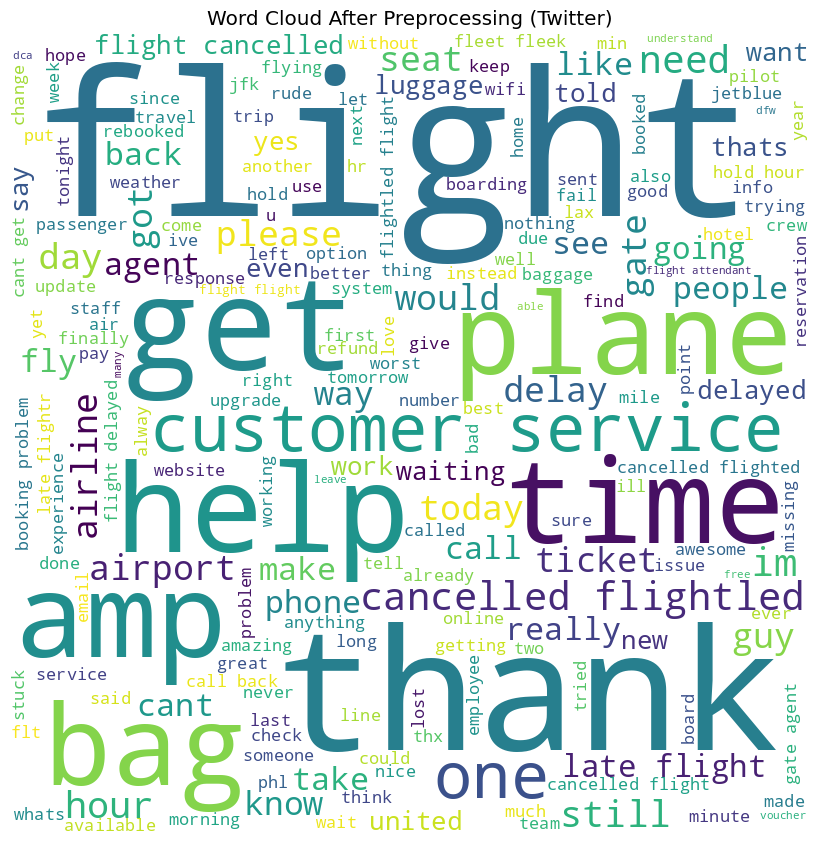

In [24]:
# Visualize word cloud after preprocessing for Twitter dataset
generate_wordcloud(' '.join(df['text'].values), 'Word Cloud After Preprocessing (Twitter)')

#### **IMDb**

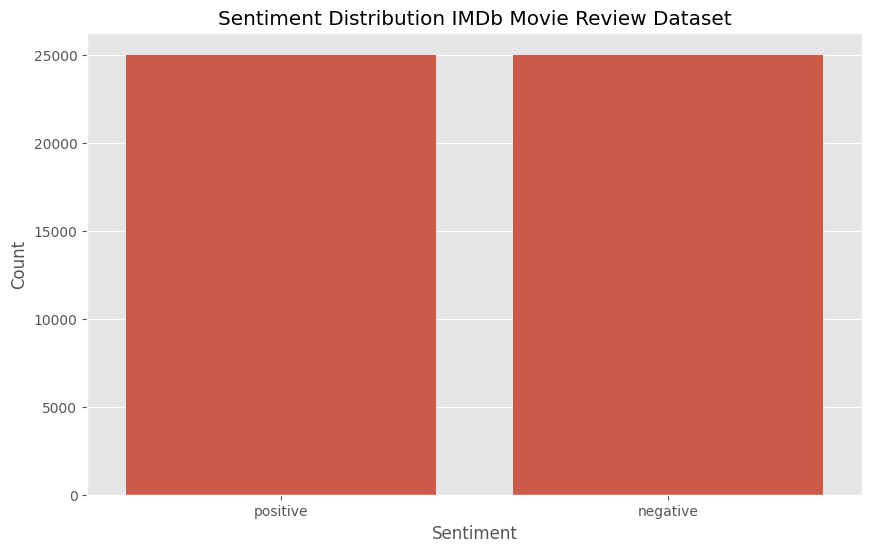

In [25]:
# Visualize sentiment distribution after preprocessing
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df2)
plt.title('Sentiment Distribution IMDb Movie Review Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

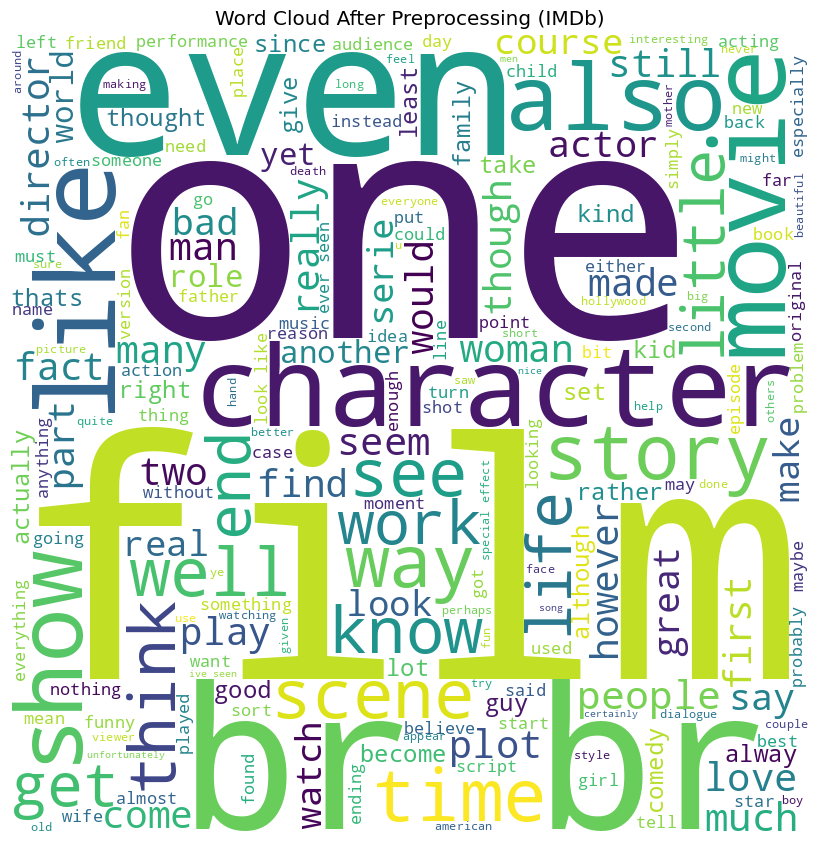

In [26]:
# Visualize word cloud after preprocessing for IMDb dataset
generate_wordcloud(' '.join(df2['review'].values), 'Word Cloud After Preprocessing (IMDb)')

### **Converting labels into integers or numeric values for ML**
**The purpose of this conversion is so that machines can understand the labels, since they aren't able to understand text data**

In [27]:
# create a new column called data and link the airline_sentiment to it
# (this 'label' column will have numbers indicating 1, 0, -1
# (positive, neutral, negative)
df['label'] = df['airline_sentiment'].apply(lambda x: int(1) if str(x) == 'positive' else (0 if x == 'neutral' else -1))
df2['label'] = df2['sentiment'].apply(lambda x: int(1) if x == 'positive' else (0 if x == 'neutral' else -1))

In [28]:
df[['airline_sentiment', 'text', 'label']].head(20)

,airline_sentiment,text,label
0,neutral,said,0
1,positive,plus added commercial experience tacky,1
2,neutral,today must mean need take another trip,0
3,negative,really aggressive blast obnoxious `` entertain...,-1
4,negative,really big bad thing,-1
5,negative,seriously would pay 30 flight seat playing rea...,-1
6,positive,"yes , nearly every time fly “ ear worm ” won ’...",1
7,neutral,really missed prime opportunity men without ha...,0
8,positive,"well , didnt…but do d",1
9,positive,"amazing , arrived hour early good me",1


## **Feature Extraction: TF-IDF Vectorisation**

### **Split the Dataset into Training and Testing**

In [29]:
text_train, text_test, label_train, label_test = train_test_split(
    df['text'].values, df['label'].values, test_size = 0.2, random_state = 42, stratify=df['label'].values
)

In [30]:
print(len(text_train), len(text_test), len(label_train) , len(label_test))

11712 2928 11712 2928


### **TF-IDF**

In [31]:
# # initialise the tf-idf vectoriser (or model) and store it in a variable
# tfidf_vector = TfidfVectorizer()

# # Fit and transform the entire dataset
# tfidf_matrix = tfidf_vector.fit_transform(df['text'])

# # Display the TF-IDF vocabulary
# print("Vocabulary:", tfidf_vector.vocabulary_)

# # Place the TF-IDF matrix into a DataFrame
# tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns=sorted(tfidf_vector.vocabulary_))

# # Display the TF-IDF DataFrame
# print(tfidf_df)

# # Transform the training and testing sets
# tfidf_train = tfidf_vector.transform(text_train)
# # tfidf_test = tfidf_vector.transform(text_test)
# tfidf_test = tfidf_vector.transform(df2['review'].values)

In [32]:
# Initialize the TF-IDF vectorizer and store it in a variable
tfidf_vector = TfidfVectorizer()

# Transform the training and testing sets
tfidf_train = tfidf_vector.fit_transform(text_train)
tfidf_test = tfidf_vector.transform(text_test)

## **Training SVM**

In [33]:
# train the SVM model
svm = SVC(kernel='linear')

svm.fit(tfidf_train, label_train)

SVC(kernel='linear')

## **Testing SVM**

In [34]:
# Test the SVM model
tfidf_test_imdb = tfidf_vector.transform(df2['review'].values)

predictions_imdb = svm.predict(tfidf_test_imdb)

print('==============================================')
print('\nClassification Report\n')
print('==============================================')

accuracy = accuracy_score(df2['label'].values, predictions_imdb)
accuracy_perc = accuracy * 100

print(f"Accuracy on IMDb dataset: {accuracy_perc:.2f}%")
print('---------------------------\n')

# print(classification_report(label_test,predictions))
print(classification_report(df2['label'], predictions_imdb, zero_division=1))


Classification Report

Accuracy on IMDb dataset: 59.49%
---------------------------

              precision    recall  f1-score   support

          -1       0.56      0.97      0.71     25000
           0       0.00      1.00      0.00         0
           1       0.91      0.21      0.35     25000

    accuracy                           0.59     50000
   macro avg       0.49      0.73      0.35     50000
weighted avg       0.73      0.59      0.53     50000



In [35]:
df2.head(20)

,review,sentiment,label
0,one reviewer mentioned watching episode hooked...,positive,1
1,wonderful little production br br the filming ...,positive,1
2,thought wonderful way spend time hot summer we...,positive,1
3,basically there family little boy jake think t...,negative,-1
4,petter matteis `` love time money '' visually ...,positive,1
5,"probably alltime favorite movie , story selfle...",positive,1
6,sure would like see resurrection dated seahunt...,positive,1
7,"show amazing , fresh innovative idea 70 first ...",negative,-1
8,encouraged positive comment film looking forwa...,negative,-1
9,like original gut wrenching laughter like movi...,positive,1


### **Confusion Matrix**

In [36]:
print(confusion_matrix(df2['label'], predictions_imdb))

[[24375    95   530]
 [    0     0     0]
 [19374   257  5369]]


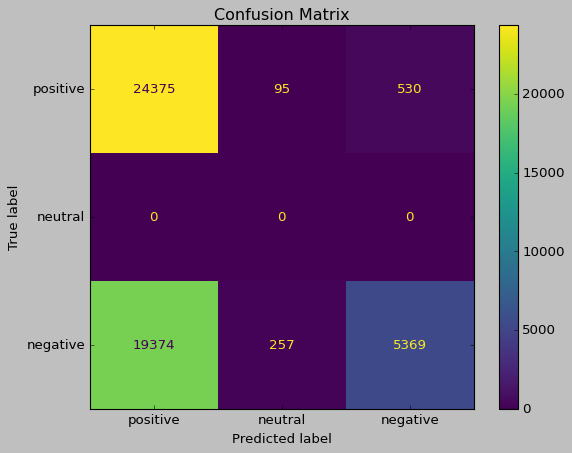

In [37]:
style.use('classic')
cm = confusion_matrix(df2['label'], predictions_imdb)

# Display confusion matrix
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['positive', 'neutral', 'negative'])
display_cm.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.show()

## **Hyperparameter**

### **Using GridSearchCV**

In [38]:
# define the hyperparameter grid
# parameter_grid ={
#     'C': [0.01, 0.1, 1, 10],
#     'kernel': ['linear', 'rbf'],
#     'gamma': [0.01, 1]
# }

In [39]:
# grid = GridSearchCV(svm, parameter_grid, cv=5)
# grid.fit(tfidf_train, label_train)

In [40]:
# Print the best hyperparameters
# print("Best Hyperparameters:", grid.best_params_)

In [41]:
# Get the best SVM model
# best_svm_model = grid.best_estimator_

# Test the best SVM model
# predictions_imdb_best = best_svm_model.predict(tfidf_test)

In [42]:
# Display the classification report and confusion matrix for the best model
# print('\n==============================================')
# print('Classification Report for Best Model\n')
# print('==============================================')

# accuracy = accuracy_score(df2['label'].values, predictions_imdb)
# accuracy_perc = accuracy * 100

# print(f"Accuracy on IMDb dataset: {accuracy_perc:.2f}%")
# print('---------------------------\n')

# print(classification_report(df2['label'], predictions_imdb_best, zero_division=1))

# Calculate confusion matrix for best model
# cm_best = confusion_matrix(df2['label'], predictions_imdb_best)

# Display confusion matrix for best model
# display_cm_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=['positive', 'neutral', 'negative'])
# display_cm_best.plot(cmap='viridis', values_format='d')

# plt.title('Confusion Matrix for Best Model')
# plt.show()